In [9]:
import math
import numpy as np
import matplotlib.pyplot as plt

I want to model the takeoff of this plane, from starting the motor to stabilization. First I need the equations of motion for the initial takeoff, accelerating from zero and then adding in drag and lift at different angles, until takeoff is possible.

In [10]:
#Max weight kg
plane_mass = 25 / 2.204

#for determining ground effect distance, chord times aspect ratio (meters)
wing_span = 16.5*7.5  *0.0254

#percent thickness by chord, times chord by aspect ratio, plus the cabbin front area, (meters^2)
frontal_area = ((0.157 * 16.5**2 * 7.5)  +  (15*12)  )*0.0254**2

#Wing area plus underside of fuselage, will act as lifting body with some efficiency factor, (inches^2)
wing_area = ((16.5**2 * 7.5) + (51*14*0.8) )*0.0254**2

x_0 = 0
v_0 = 0
a_0 = 0

#in slugs/ft^3, equivalent to 1.225 kg/m^3
air_density = 1.225 

The ground effect here is estimated, noting that is decreaces induced drag by 1.4% at $\frac{y}{b} = 1$, 23.5% at $\frac{y}{b}=0.25$, and 47.6% at $\frac{y}{b}=0.1$. These are the coefficents, a kinda important part of teh whole process, made on estiamations of the airfoil and papers about the ground effect. These are fit using wolfram Alpha.

In [71]:
#ground effect approximation based on data from https://code7700.com/aero_ground_effect.htm
def g_effect(y):
    L_c = y/wing_span
    return 1-0.757974*math.exp(-4.66314*L_c)


#rough Cl for a range of angles and reducing when out of the ground envelope and flaps are disabled
def Cl(alpha, y):
    cl=0.7
    if alpha < -8.0:
        cl = 0.0
    elif -8.0 <= alpha <= 10.0:
        cl = 0.000669839*alpha**2 + 0.104523*alpha + 0.699226
    elif 10.0 < alpha <= 11.75:
        cl = 1.7
    elif 11.75 < alpha <= 17.0:
        cl = 2.17515 - 0.0396471*alpha
    else:
        cl = 0.0
        
    if y/wing_span < 5.0:
        #maximum CL plus an additional 0.7, even though these flaps are supposed to give anywhere from 0.7-0.9
        cl += 0.7 
    elif 15.0 < y <= 30.48 :
        cl = 0.5
    elif y > 30.48:
        cl = 0.60
    return cl

#three-part Cd baesed on Cl, height, and speed
def Cd(alpha, y, v):
    e_0 = 0.7
    if alpha < -2.0:
        cd_airfoil = 0.000140654 - 0.0103897*alpha
    elif -2.0 <= alpha < 10.0:
        cd_airfoil = 0.0193
    else:
        cd_airfoil = 0.01282*alpha - 0.1098
    cd_craft = 0.0 #will add flat plate drag for the nose cone later
    cd_induced = g_effect(y) * Cl(alpha, y)**2 / (math.pi * e_0 * 7.5)
    total_Cd = cd_airfoil + cd_craft + cd_induced
    return  total_Cd

In [31]:
Cl(3,14.0)

1.718823551

This is first a simple looking at, with these forces only in their directional axis. Later I'll put in the architecture to have, for example, at 10 degrees, a component of lift up and back rather than only up. Gravity will stay down, but the direction of the other three depend on velocity or anlge of attack. There's a built in 3 degree angle of incidence.

These are the equations of motion, all scaling with velocity:

$$ \ddot{x} = \frac{F_{th} - F_D}{m} = \frac{Th_{motor}}{m} - C_d \rho \frac{v^2}{2m} A_f$$\
$$ \ddot{y} = \frac{F_l - F_g}{m}  = C_L \rho \frac{v^2}{2m} A_t - g $$

These differential equations will be solved numerically using the Runga Kutta 4 (RK4) method.

In [15]:
def RK_four(F,x_not,dt,N):
    time_vals = np.arange(0,(N+1)*dt,dt)
    #make array, change values later for the sake of time savings
    f_vals = np.array([x_not]*(N+1))
    for i in range(N):
        k1 = dt * F(f_vals[i],time_vals[i])
        k2 = dt * F(f_vals[i]+(k1/2),time_vals[i]+(dt/2))
        k3 = dt * F(f_vals[i]+(k2/2),time_vals[i]+(dt/2))
        k4 = dt * F(f_vals[i]+k3,time_vals[i]+dt)
        f_vals[i+1] = f_vals[i] + ( k1 + 2*k2 + 2*k3 + k4)/6
    return time_vals, f_vals

These are the forces on the plane, divided by the plane's mass to produce the component of acceleration on the craft by this force.

In [16]:
#'up' with respect to the wing
def lift_acc(alpha,y,true_speed):
    return  np.sign(true_speed) * Cl(alpha,y) * 0.5 * true_speed**2 * air_density * wing_area / plane_mass

#opposite the direction of the wind
def drag_acc(alpha,y,true_speed):
    return np.sign(true_speed) * Cd(alpha,y,true_speed) * 0.5 * true_speed**2 * air_density * frontal_area / plane_mass 

def vert_drag(alpha,y,vertical_speed):
    return np.sign(vertical_speed) * Cd(alpha,y,vertical_speed) * 0.5 * vertical_speed**2 * air_density * wing_area / plane_mass

#down at all times
gravity_acc = 9.8067

#forwards at all times
def Thrust_acceleration(v):
    prop_length = 28*0.0254
    prop_pitch = 10.1*0.0254
    omega = 3248/60.0
    prop_area = math.pi*(prop_length/2)**2
    verbose = air_density * prop_area * (prop_length/(3.29546*prop_pitch))**1.5 * ((omega*prop_pitch)**2-(v*omega*prop_pitch))/plane_mass
    #short = (72.4 - (v*5.2))/plane_mass
    return verbose

In [81]:
#takes as initial conditions, x,y,vx,vy, and supplies vx,vy,ax,ay
def AccelerationSummation(f,t):
    #both components of velocity averaged with the prop's wind speed
    true_speed = math.sqrt(f[2]**2)
    #bounding the y value not to be negative; theres a ground. Also changing angle of attack for flight phases
    alpha = 3.0
    if f[1] < 0.0:
        f[1] = 0.0
        alpha = 3.0
    elif 2.0 < f[1] < 20.0:
        alpha = 12.0
    H_drag = drag_acc(alpha,f[1],true_speed)
    #we're operating at about 60% of what the motor can do because of watt minitations, so this is to compensate
    lift = 0.6*lift_acc(alpha,f[1],true_speed)
    y_acceleration = lift - gravity_acc - vert_drag(alpha,f[1],f[3])
    if y_acceleration < 0.0 and f[1] == 0.0:
        y_acceleration = 0
    return np.array([f[2],f[3], Thrust_acceleration(f[2]) - H_drag, y_acceleration])

In [50]:
AccelerationSummation([0.0,0.0,10.0,10.0],0.001)

array([10.        , 10.        ,  1.67779404,  0.57578606])

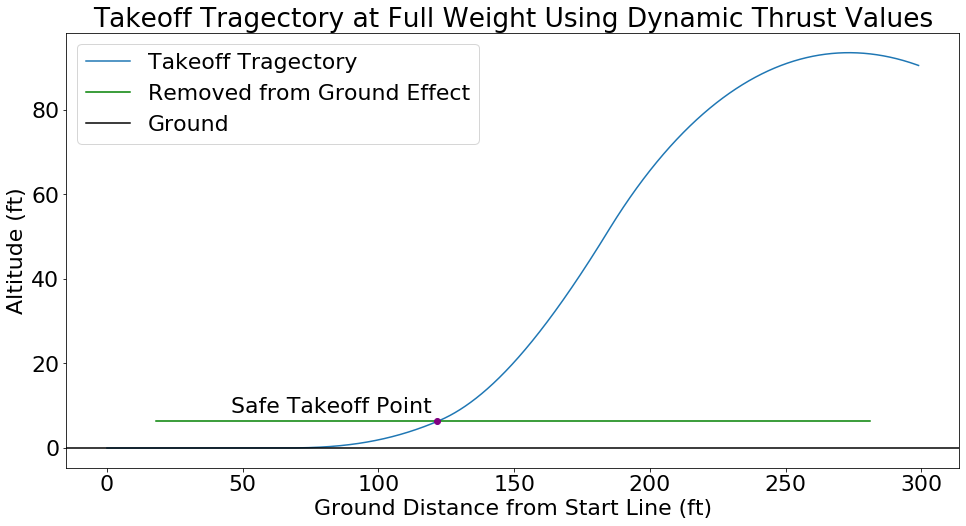

<Figure size 432x288 with 0 Axes>

In [105]:
N = 9000
dt = 0.001
off_ground = 2*3.14
takeoff_dist = 0

data = RK_four(AccelerationSummation,[0.0,0.0,0.0,0.0],dt,N-1)
#converting meters to feet
y_data = np.array([d[1] for d in data[1]])*3.28084
x_data = np.array([d[0] for d in data[1]])*3.28084

for i in range(len(x_data)):
    if round(y_data[i],2) == off_ground:
        takeoff_dist = x_data[i]
        
plt.figure(figsize=(16,8))

plt.plot(x_data,y_data,)
plt.axhline(off_ground,xmin=0.1, xmax=0.9,color='green')
plt.axhline(0,color='black')
plt.plot(takeoff_dist,off_ground,marker = 'o',color='purple')

plt.rcParams.update({'font.size': 22})
plt.ylabel("Altitude (ft)")
plt.xlabel("Ground Distance from Start Line (ft)")
plt.title('Takeoff Tragectory at Full Weight Using Dynamic Thrust Values')
plt.legend(['Takeoff Tragectory','Removed from Ground Effect','Ground'])
plt.text(takeoff_dist-2,off_ground+2,'Safe Takeoff Point',horizontalalignment='right')
plt.show()
plt.savefig('plot.png')
